## 1 - Load relevant libraries

In [1]:
# Here I just collate a few pacakages from the lecture to ensure we will have everything we need
# If we actually do so or not ;-)

%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sklearn
import sklearn.model_selection as skl
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve 

import tensorflow as tf
import skimage
from skimage import io
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from random import sample

from itertools import chain
import scipy
import scipy.stats

from scipy.ndimage import gaussian_filter

## fix random_state for reproducibility
random_state = 42


Using TensorFlow backend.


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
21237,00005679_002.png,No Finding,2,5679,62,M,AP,2500,2048,0.171,0.171,NaN
60134,00014839_021.png,No Finding,21,14839,30,F,AP,2500,2048,0.168,0.168,NaN
61421,00015160_021.png,No Finding,21,15160,39,F,AP,2500,2048,0.168,0.168,NaN


In [3]:
data_sample = pd.read_csv('sample_labels.csv')
data_sample.sample(3, random_state=random_state)

data_sample_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('./project1_images', 'images*', '*', '*.png'))}
data_sample['path'] = data_sample['Image Index'].map(data_sample_paths.get)
data_sample.sample(3, random_state=random_state)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2146,00011065_007.png,No Finding,7,11065,066Y,M,PA,2992,2991,0.143,0.143,None
1879,00009892_001.png,No Finding,1,9892,062Y,F,PA,2992,2991,0.143,0.143,None
346,00001836_076.png,Mass|Nodule,76,1836,050Y,F,AP,2500,2048,0.168,0.168,None


## 2 - EDA

Let's look at some of the data in detail!

My EDA will be covering the following aspects:<br>
Population: age distribution, gender distribution, disease distribution, diseases per unique patient<br>
Pneuomnia Sample: age distribution, gender distribution, disease distribution (to identify parallel occurences of other diseases with pneumonia)<br>
Image intensity: Pneumonia, No Finding, other diseases
<br>
So let's roll!

In [4]:
## Before investigating the data I'll create a binary classification for all diseases, so we can identify occurences more easily. 
## If Existing = 1; Non-Existent = 0; Unique column per Findings Label

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for label in all_labels:
    if len(label)>1: # leave out empty labels
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
all_xray_df.sample(10)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
20830,00005564_011.png,Infiltration,11,5564,43,F,AP,2500,2048,0.171000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
101706,00027028_017.png,Effusion,17,27028,58,M,PA,2021,2021,0.194314,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69558,00017138_104.png,Infiltration,104,17138,24,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
39613,00010352_061.png,Cardiomegaly|Edema|Effusion,61,10352,32,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35825,00009437_012.png,No Finding,12,9437,40,F,PA,2386,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19404,00005140_012.png,Emphysema|Pneumothorax,12,5140,61,F,PA,2021,2020,0.194311,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
59470,00014696_001.png,No Finding,1,14696,53,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21335,00005690_000.png,Atelectasis,0,5690,61,M,AP,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12733,00003344_001.png,Fibrosis,1,3344,66,M,PA,2500,2048,0.171000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109985,00029926_000.png,No Finding,0,29926,33,F,PA,2021,2020,0.194311,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
#Now lt'S look at some general distribution data of the dataset.

all_xray_df.describe()

,Follow-up #,Patient ID,Patient Age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Atelectasis,Cardiomegaly,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0,112120.000000,112120.000000,...,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN,0.103095,0.024759,...,0.022440,0.015037,0.002025,0.177435,0.051570,0.538361,0.056466,0.030191,0.012763,0.047289
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN,0.304084,0.155391,...,0.148111,0.121702,0.044950,0.382038,0.221158,0.498529,0.230821,0.171113,0.112251,0.212256
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


What can we learn from that view? <br>
- From Follow-up # we see that we have a set of data comprised of regular condition check (as Follow-Up up to 183), but also some one-off checks (as minimum at 0).<br>
- Patient ID tells us that we have the promised 30,805 Unique patients and the 112,120 unique images <br>
- Patient Age seems to have some outliers, as Age 414 is maximum value and min value is 1...<br>
- Images have differing scale, will need to be harmonized for model training <br>
- Mean occurence of Pneumonia is in app. 1.3% of the cases. This needs to be regarded in definition of the validation dataset in model training.

#### So let's get started! First, as promised, a detailed view on the population!

#### Age distribution:

(array([4.2500e+02, 9.7800e+02, 1.5330e+03, 2.3050e+03, 3.7610e+03,
        5.1570e+03, 5.4630e+03, 8.3900e+03, 6.1900e+03, 7.2630e+03,
        9.1310e+03, 9.4600e+03, 1.0774e+04, 1.1726e+04, 9.3080e+03,
        9.9210e+03, 4.5270e+03, 3.0580e+03, 1.6150e+03, 7.4500e+02,
        2.5600e+02, 9.4000e+01, 2.4000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        3.0000e+00, 4.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

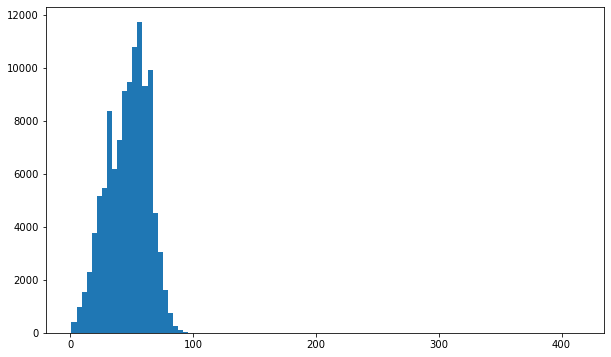

In [6]:
plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'], bins = 100)

Age Modus seems to be at around 60 years old. Fairly distributed. <br>
But also seems we are having some outliers when it comes to Age... <br>
We can see that a few outliers beyond realistic age or of very young patients are included in the dataset.<br>
That might be critical for our model quality and complicate communication to the FDA. <br>
We have different strategies here:<br>
- We could try to find age data that fits the unique patients and replace.<br>
- We simply discard the data, which would cost us a few.<br>
- We accept the outliers to not loose any data.<br>

In [7]:
## Let's have a closer look at those Age outliers, defined by me as >=100 and <=5 years of age.

Age_outliers = sorted(i for i in all_xray_df['Patient Age'] if i >= 100 or i <= 5)
len(Age_outliers)

441

In [8]:
age_100 =  all_xray_df[all_xray_df['Patient Age']>100]
print(age_100.shape)

(16, 27)


In [9]:
age_100.head(16)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [10]:
age_lower5 =  all_xray_df[all_xray_df['Patient Age']<=5]
print(age_lower5.shape)

(425, 27)


In [11]:
age_lower5.sample(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
45956,00011766_000.png,No Finding,0,11766,4,M,AP,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
22442,00005956_000.png,Atelectasis|Infiltration,0,5956,4,M,AP,2048,2500,0.115,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
30392,00007924_000.png,No Finding,0,7924,4,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
57960,00014352_002.png,No Finding,2,14352,5,M,PA,2642,1909,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
40055,00010460_000.png,No Finding,0,10460,5,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
88792,00022010_000.png,Cardiomegaly|Effusion,0,22010,2,M,PA,1758,1738,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28496,00007438_000.png,No Finding,0,7438,5,F,AP,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
70859,00017477_000.png,No Finding,0,17477,4,M,AP,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10564,00002733_000.png,No Finding,0,2733,5,M,AP,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
23409,00006205_000.png,No Finding,0,6205,4,M,AP,2048,2500,0.115,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


We do have a small volume in outliers (441/112120), which will not cause too much irritation. <br>
I could further investigate, and adapt, but as I have seen above other columns don't show significant error for those cases. <br>

(array([0.000e+00, 1.600e+01, 8.300e+01, 8.400e+01, 1.050e+02, 1.370e+02,
        2.030e+02, 2.060e+02, 1.870e+02, 3.820e+02, 4.000e+02, 3.640e+02,
        3.360e+02, 4.330e+02, 4.760e+02, 5.400e+02, 6.840e+02, 6.050e+02,
        7.000e+02, 8.830e+02, 9.880e+02, 1.190e+03, 1.252e+03, 1.296e+03,
        1.342e+03, 1.267e+03, 1.248e+03, 1.290e+03, 1.535e+03, 1.390e+03,
        1.631e+03, 1.619e+03, 1.688e+03, 1.661e+03, 1.791e+03, 1.712e+03,
        1.419e+03, 1.444e+03, 1.615e+03, 1.733e+03, 2.020e+03, 1.609e+03,
        1.901e+03, 2.067e+03, 2.184e+03, 2.397e+03, 2.483e+03, 2.270e+03,
        2.332e+03, 2.468e+03, 2.390e+03, 2.556e+03, 2.891e+03, 2.578e+03,
        2.749e+03, 2.830e+03, 2.916e+03, 2.771e+03, 3.209e+03, 2.516e+03,
        2.385e+03, 2.238e+03, 2.169e+03, 2.149e+03, 2.037e+03, 2.113e+03,
        1.974e+03, 1.648e+03, 1.337e+03, 1.222e+03, 1.014e+03, 9.540e+02,
        9.100e+02, 9.330e+02, 6.310e+02, 5.840e+02, 5.600e+02, 4.530e+02,
        3.400e+02, 2.620e+02, 2.380e+0

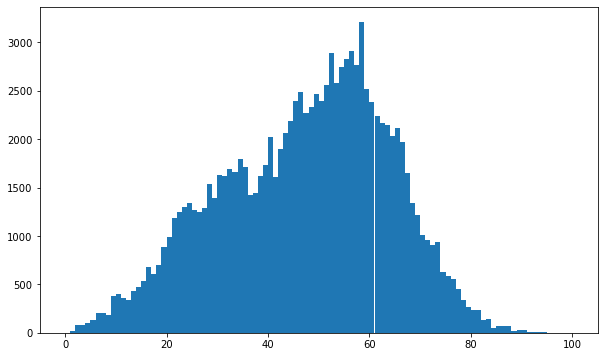

In [12]:
## Let's have a closer look at age distribution in the realistic frame from 0 to 100.

plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient Age'], range=(0,100), bins = 100)

We can see that age distribution is peaking at around age 58. <br>
The main dataframe is between 20 and 70, we could / should focus our later FDA communication on this... <br>
Let's have a closer look.


In [13]:
scipy.stats.mode(all_xray_df['Patient Age'])

ModeResult(mode=array([58]), count=array([3209]))

As we can hardly communicate to the FDA that our model will cover patients of age from 1 up to 414 I consider to rescope the database. <br>
Let's focus on the age segments covering 90% of the data for communication.

In [14]:
all_xray_df['Patient Age'].quantile(0.05)

18.0

In [15]:
all_xray_df['Patient Age'].quantile(0.95)

72.0

Sounds reasonable, but we would loose 10% of data. <br>
I decide at this stage to run model development based on the full data, but to communicate to the FDA that it is put to best use for patients aged 18 to 72. <br>

#### Patient IDs

(array([1215., 1135., 1099., 1107., 1149., 1281., 1213., 1293., 1222.,
        1117., 1086., 1356., 1006.,  851., 1105., 1360., 1110., 1063.,
        1349., 1154., 1333., 1188., 1413., 1129., 1261., 1140., 1095.,
        1136., 1163.,  937., 1094., 1186., 1555., 1197., 1715., 1179.,
        1311., 1413., 1445., 1470., 1240., 1367., 1231., 1182., 1679.,
        1700., 1531., 1318., 1343., 1050., 1398., 1236., 1166., 1306.,
        1267., 1438., 1167., 1286., 1344., 1436., 1188., 1220., 1368.,
        1126., 1240., 1316., 1190., 1054., 1190., 1098., 1077.,  948.,
        1082.,  933., 1216.,  922.,  414.,  336.,  364.,  325.,  317.,
         798.,  941., 1085.,  929., 1012.,  869., 1058.,  933.,  961.,
         858.,  755.,  935.,  912.,  847.,  793.,  929.,  924.,  690.,
         651.]),
 array([1.000000e+00, 3.090400e+02, 6.170800e+02, 9.251200e+02,
        1.233160e+03, 1.541200e+03, 1.849240e+03, 2.157280e+03,
        2.465320e+03, 2.773360e+03, 3.081400e+03, 3.389440e+03,
        3.

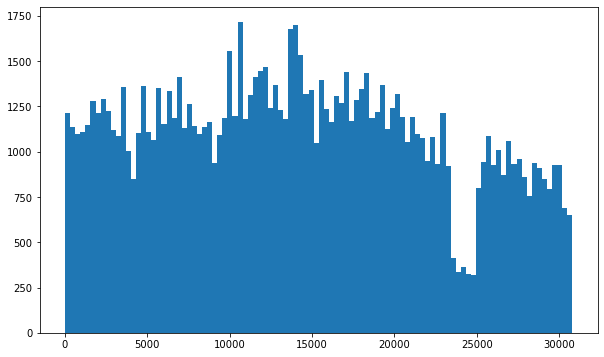

In [16]:
## Now let's have a look if some of the app. 30,000 patients occur more often 
## than others and therefore might skew the view on Patient Age.

plt.figure(figsize=(10,6))
plt.hist(all_xray_df['Patient ID'], bins=100)

In [17]:
### OK, obviously some IDs occur more often than others within the dataset. 
### Let's have a look on the mode to see how often the most often recorded patient is in there.

scipy.stats.mode(all_xray_df['Patient ID'])

ModeResult(mode=array([10007]), count=array([184]))

Wow, ok, so ID 10007 is 184 times within the dataset. <br>
That is a major skew. Guess the age of this patient...

In [85]:
ID_10007 =  all_xray_df[all_xray_df['Patient ID']==10007]
print(ID_10007.sample(5))

            Image Index         Finding Labels  Follow-up #  Patient ID  \
38184  00010007_103.png           Cardiomegaly          103       10007   
38099  00010007_018.png             No Finding           18       10007   
38151  00010007_070.png             No Finding           70       10007   
38220  00010007_139.png  Cardiomegaly|Effusion          139       10007   
38084  00010007_003.png                  Edema            3       10007   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
38184           58              M            AP                 2500     2048   
38099           58              M            AP                 2500     2048   
38151           58              M            AP                 2500     2048   
38220           59              M            AP                 2500     2048   
38084           58              M            AP                 2500     2048   

       OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis  

As expected, this very often occuring patient is age 58 (and in later image data 59) and therefore the distribution is skewed... <br>
But never mind - we look to investigate the imaging data, therefore many pictures of the same patient will help us as well!

#### Age distribution per disease

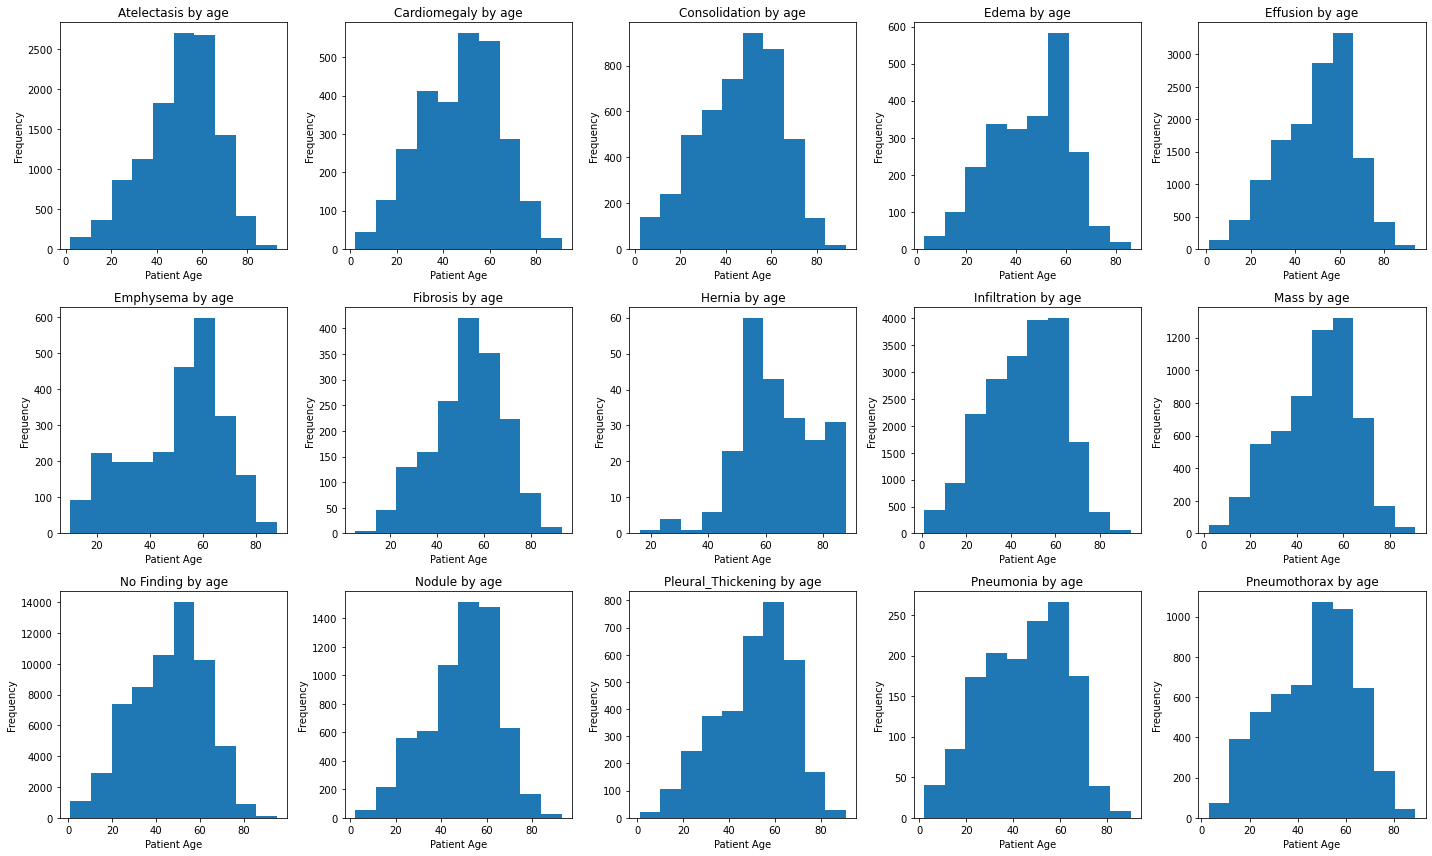

In [19]:
# as before I'll focus this view on the range from 1 to 100
age_scoped = all_xray_df[all_xray_df['Patient Age'] < 100]

fig = plt.subplots(figsize = (20, 12))
for ind, label in enumerate(all_labels):
    plt.subplot(3, 5, ind+1)
    plt.subplots_adjust(hspace = 1.0)
    plt.hist(age_scoped[age_scoped[label] == 1.0]['Patient Age'])
    plt.xlabel('Patient Age')
    plt.ylabel('Frequency')
    plt.title('%s by age'%label)
    plt.tight_layout()

Pneumonia distribution seems to be very similar to the general population. Very good! <br>
Detailed view below.

In [20]:
### Create pneup = Penumonia patients / images
pneup =  all_xray_df[all_xray_df.Pneumonia==1.0]
pneup.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
68210,00016825_000.png,Pneumonia,0,16825,52,F,PA,2360,2271,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6524,00001749_003.png,Pneumonia,3,1749,49,M,PA,2970,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
74750,00018360_012.png,Edema|Pneumonia,12,18360,62,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


(array([ 0.,  0.,  1.,  4.,  2.,  6.,  2.,  8.,  3., 13.,  2.,  5., 10.,
         8.,  9., 11., 16.,  8.,  8., 10., 10., 16., 20., 26., 24., 19.,
        24., 14., 21., 16., 20., 26., 23., 40., 25., 18., 17., 18., 27.,
        27., 26., 13., 19., 30., 23., 31., 23., 18., 34., 34., 25., 17.,
        28., 39., 25., 29., 34., 28., 36., 29., 34., 24., 22., 30., 19.,
        30., 34., 22., 20., 17., 10., 12., 11.,  6.,  4.,  5.,  8.,  6.,
         1.,  4.,  3.,  2.,  2.,  2.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  6

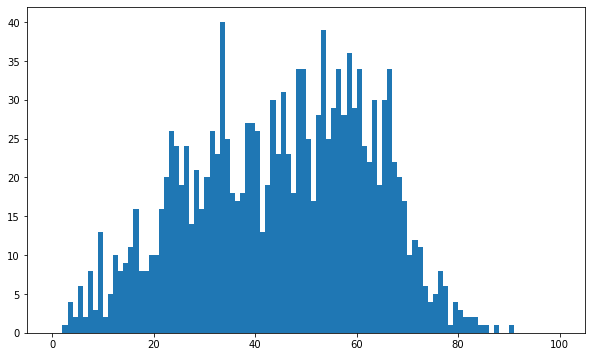

In [21]:
plt.figure(figsize=(10,6))
plt.hist(pneup['Patient Age'], range=(0,100), bins = 100)

#### Gender distribution

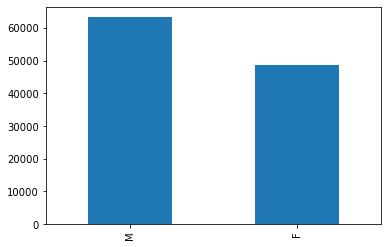

In [22]:
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')

In [23]:
### We seem to have more images of Male patients.
### Let's look at the shares in figures.
all_xray_df['Patient Gender'].value_counts(normalize=True) * 100

M    56.493043
F    43.506957
Name: Patient Gender, dtype: float64

56.5% are male, which is higher than the general population (app. 51 Female, 49 Male). <br>
We'll inform the FDA about that in the documentation.

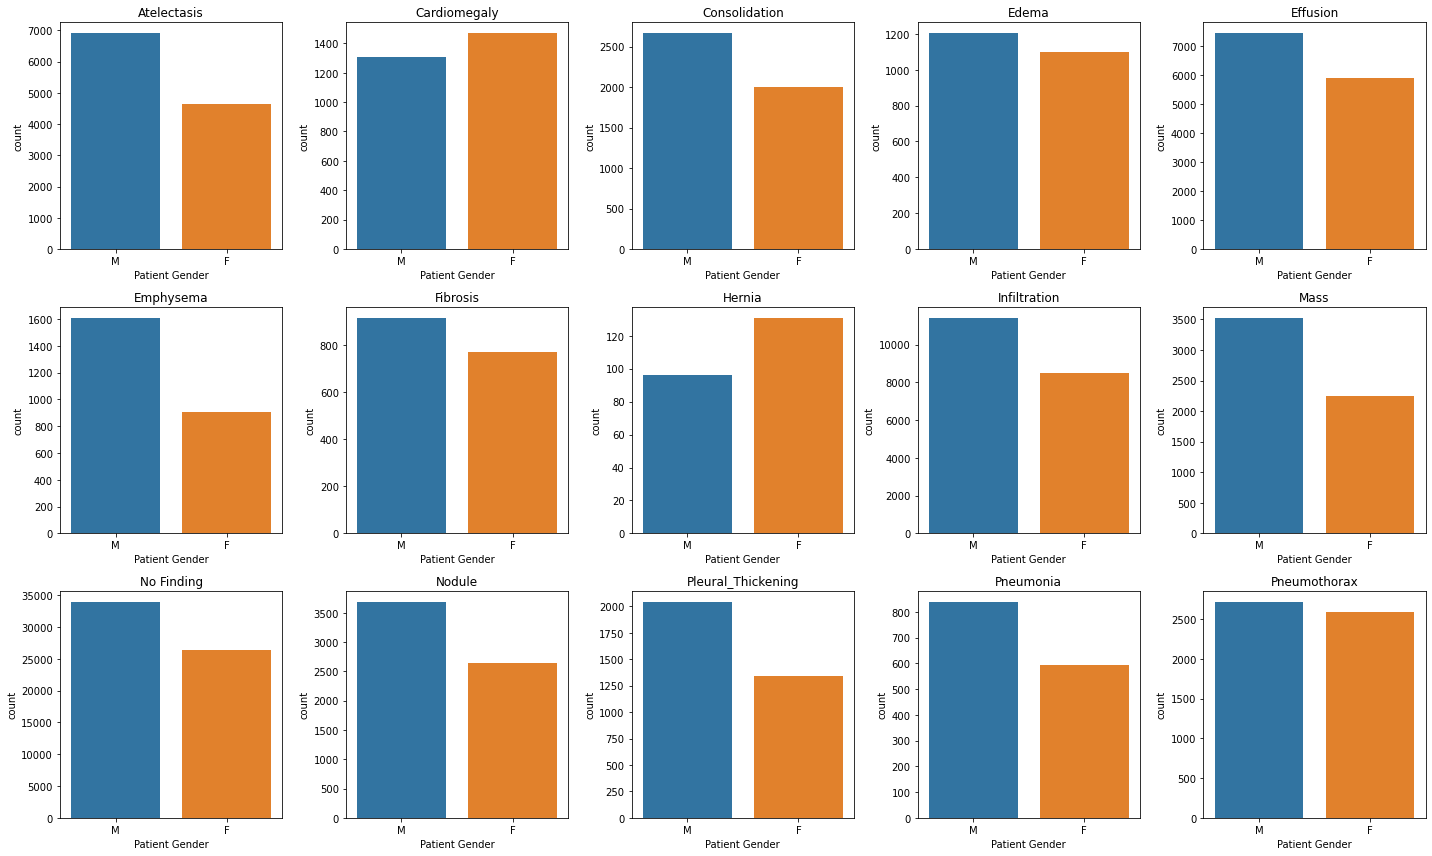

In [24]:
### Let's have a look on gender distribution per disease.

fig = plt.subplots(figsize = (20, 12))
for ind, label in enumerate(all_labels):
    plt.subplot(3, 5, ind+1)
    plt.subplots_adjust(hspace = 1.0)
    ax = sns.countplot(x='Patient Gender',data = all_xray_df[all_xray_df[label] == 1], order=['M', 'F'])
    plt.title(label)
    plt.tight_layout()

Some observations: <br>
Some diseases, like Hernia, clearly have a different gender split. So co-occurence is potentially not that common. <br>
Pneumonia labels with similar distribution of gender than overall study population. Let's further detail.

In [25]:
pneup['Patient Gender'].value_counts(normalize = True) * 100

M    58.560447
F    41.439553
Name: Patient Gender, dtype: float64

Slightly higher proportion of Male images in the case of Pneumonia. <br> But nothing to worry about.

#### View position:

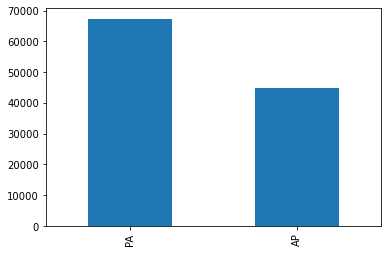

In [26]:
all_xray_df['View Position'].value_counts().plot(kind='bar')

In [27]:
 all_xray_df['View Position'].value_counts(normalize=True) * 100

PA    60.033892
AP    39.966108
Name: View Position, dtype: float64

60% of images were taken from view position PA. 

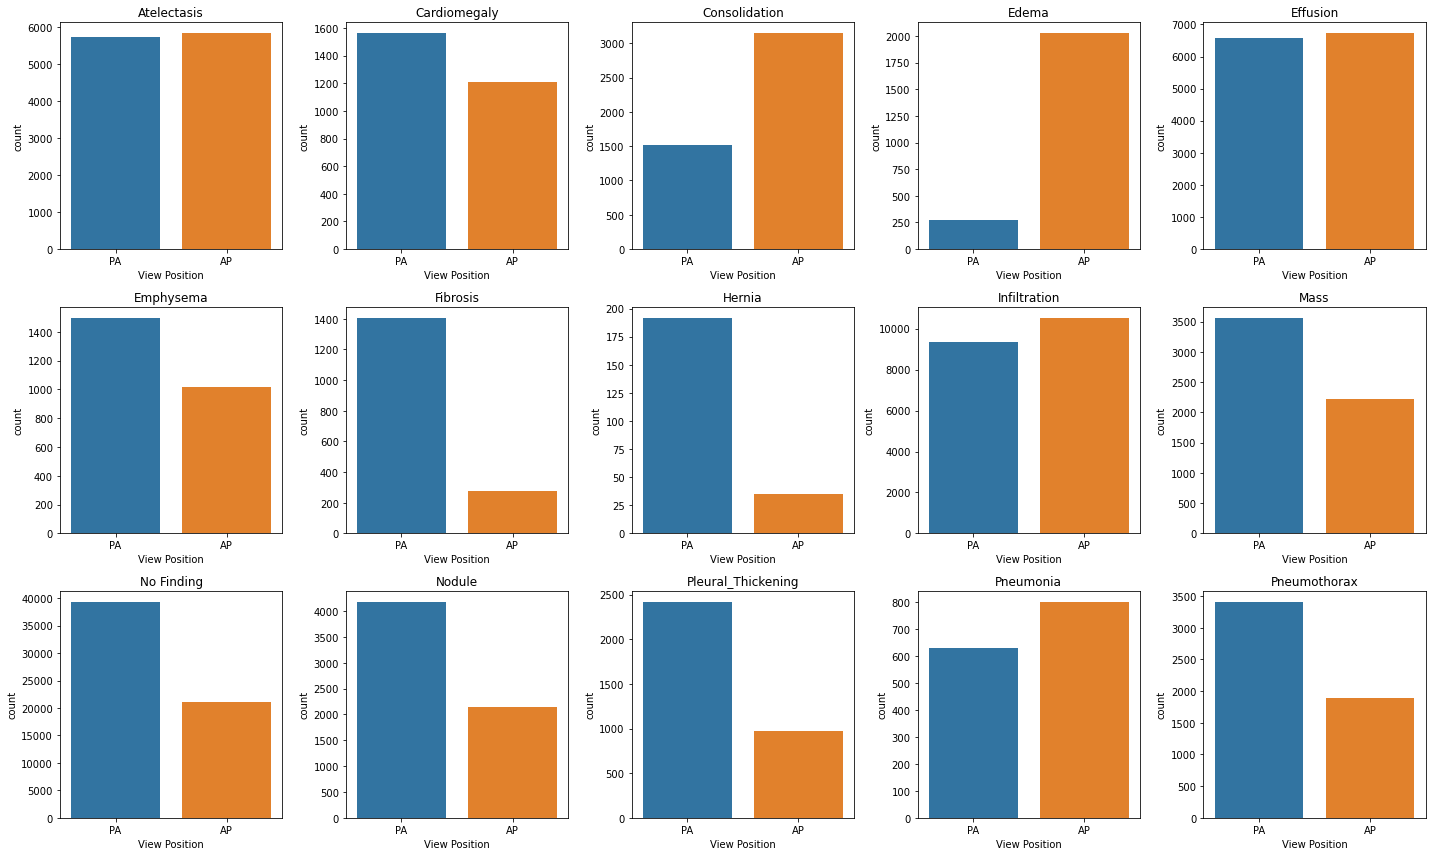

In [28]:
### Let's have a look on gender distribution per disease.

fig = plt.subplots(figsize = (20, 12))
for ind, label in enumerate(all_labels):
    plt.subplot(3, 5, ind+1)
    #ax = all_xray_df[all_xray_df[label] == 1.0]['Patient Gender'].value_counts().plot(kind='bar')
    plt.subplots_adjust(hspace = 1.0)
    ax = sns.countplot(x='View Position',data = all_xray_df[all_xray_df[label] == 1], order=['PA', 'AP'])#, hue='Patient Gender')
    plt.title(label)
    plt.tight_layout()

In [29]:
pneup['View Position'].value_counts(normalize=True) * 100

AP    55.974843
PA    44.025157
Name: View Position, dtype: float64

View position is significantly more often AP than PA in the case of Pneumonia detection. <br>
Not sure what that means, but something to keep in mind... <br>
Would need to be discussed with the data owner, or potentially also fed to the FDA to ensure, not only PA images are taken and the algorithm cannot fulfil its purpose ideally.

#### Follow-up #:

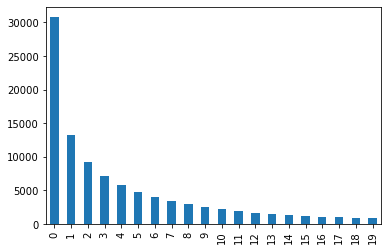

In [30]:
all_xray_df['Follow-up #'].value_counts()[0:20].plot(kind='bar')

Ok, so app 14k of the patients have a second picture in the dataframe. <br> So basically half is one-off reviews and half is multiple checks of the same patient.

#### Disease distribution:

In [31]:
## Finally a detailed view on diseases.
### What is the distribution of diseases? Let's have a look!
ax = all_xray_df[all_labels].sum()
ax

Atelectasis           11559.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2303.0
Effusion              13317.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19894.0
Mass                   5782.0
No Finding            60361.0
Nodule                 6331.0
Pleural_Thickening     3385.0
Pneumonia              1431.0
Pneumothorax           5302.0
dtype: float64

Seemingly most images show "No Finding", which can be expected on a potential screening study.<br>
Most often occuring illness is Infiltration. <br>
Pneumonia is not that common, only 1431 cases.

In [32]:
 all_xray_df['Pneumonia'].value_counts(normalize=True) * 100

0.0    98.723689
1.0     1.276311
Name: Pneumonia, dtype: float64

Sooo, as we have also seen before, only app. 1.3% of images show Pneumonia.

#### Diseases per patient:

In [33]:
### How many diseases per patient?
dpp = all_xray_df.groupby(['Patient ID'])[all_labels].sum()
dpp['sum_disease_labels'] = dpp.astype(bool).sum(axis=1)
dpp.sample(3, random_state = random_state)

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,sum_disease_labels
Patient ID,,,,,,,,,,,,,,,,
12681,8.0,1.0,2.0,1.0,5.0,0.0,0.0,0.0,4.0,0.0,32.0,3.0,0.0,0.0,0.0,8
13125,3.0,3.0,1.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,6
29707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1


In [34]:
### Oh, we got to exclude "No Finding" to be accurate here...

all_labels_2 = [label for label in all_labels if label != 'No Finding']
dpp = all_xray_df.groupby(['Patient ID'])[all_labels_2].sum()
dpp['sum_disease_labels'] = dpp.astype(bool).sum(axis=1)
dpp.sample(3, random_state = random_state)


,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,sum_disease_labels
Patient ID,,,,,,,,,,,,,,,
12681,8.0,1.0,2.0,1.0,5.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,7
13125,3.0,3.0,1.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5
29707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Text(0, 0.5, 'Number of patients')

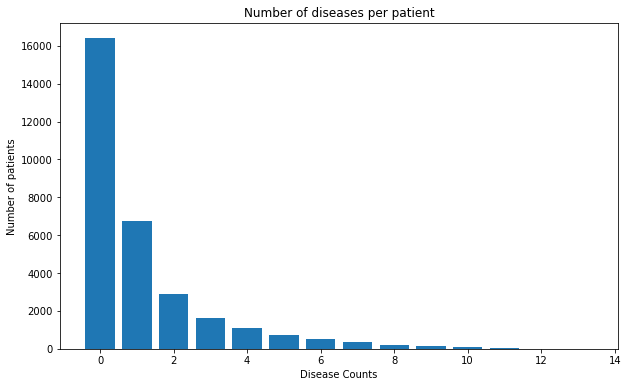

In [35]:
disease_count = dpp['sum_disease_labels'].unique()
patient_count = [dpp[dpp['sum_disease_labels'] == item].count()[0]
                 for item in disease_count]
plt.figure(figsize = (10, 6))
plt.bar(disease_count, patient_count)
plt.title('Number of diseases per patient')
plt.xlabel('Disease Counts')
plt.ylabel('Number of patients')

In [36]:
for disease, patient in sorted(zip(disease_count, patient_count)):
    if disease <=1:
        print('%d patients have %d disease => %s of all patients'
              %(patient, disease, str(format(100*patient/np.sum(patient_count), '.3f')) + " %")
             )
    else:
        print('%d patients have %d diseases => %s of all patients'
              %(patient, disease, str(format(100*patient/np.sum(patient_count), '.3f')) + " %")
             )


16403 patients have 0 disease => 53.248 % of all patients
6742 patients have 1 disease => 21.886 % of all patients
2908 patients have 2 diseases => 9.440 % of all patients
1638 patients have 3 diseases => 5.317 % of all patients
1087 patients have 4 diseases => 3.529 % of all patients
707 patients have 5 diseases => 2.295 % of all patients
518 patients have 6 diseases => 1.682 % of all patients
335 patients have 7 diseases => 1.087 % of all patients
205 patients have 8 diseases => 0.665 % of all patients
139 patients have 9 diseases => 0.451 % of all patients
84 patients have 10 diseases => 0.273 % of all patients
28 patients have 11 diseases => 0.091 % of all patients
7 patients have 12 diseases => 0.023 % of all patients
4 patients have 13 diseases => 0.013 % of all patients


We can see that over half of the patient IDs don't have a related image with a disease label. <br>
App. 6,500 patient ID have one disease label. <br>

#### Disease distribution on images

[Text(0, 0.5, 'Number of Images with Label')]

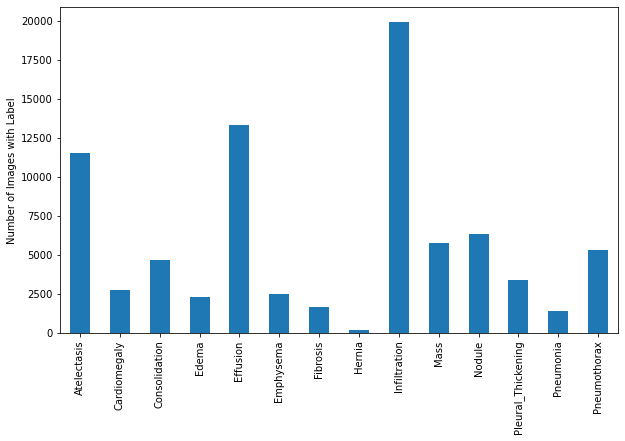

In [37]:
###Now let's review which diseases occur how often on the medical images
plt.figure(figsize = (10, 6))
all_xray_df[all_labels_2].sum()/len(all_xray_df)
ax = all_xray_df[all_labels_2].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

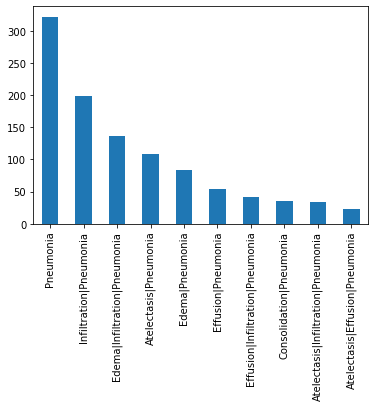

In [38]:
# Any interesting combinations of diseases with Pneumonia?
pneup['Finding Labels'].value_counts()[0:10].plot(kind='bar')

In [83]:
pneup_labels = pneup[all_labels_2].sum()
pneup_labels

Atelectasis            262.0
Cardiomegaly            41.0
Consolidation          123.0
Edema                  340.0
Effusion               269.0
Emphysema               23.0
Fibrosis                11.0
Hernia                   3.0
Infiltration           605.0
Mass                    71.0
Nodule                  70.0
Pleural_Thickening      48.0
Pneumonia             1431.0
Pneumothorax            41.0
dtype: float64

Infilitration is co-occuring in app. 600 of the 1431 cases, so nearly 45%. <br>
Edema is in app. 25% with 340 co-occurences.<br>
Effusion and Atelectasis occur in app. 20%.<br>
At least these four diseases should have balanced representations in the training and validation datasets.<br>
Very low co-occurence with Hernia, Fibrosis, Cardiomegaly, Pneumothorax and Pleural Thikening.

## 3. Image data EDA

In [40]:
## Let'S first load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000
...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,0.194311
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,0.139000
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,0.194311
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,0.194311


In [41]:
# Reassure all definitions are set:

all_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for label in all_labels:
    if len(label)>1: # leave out empty labels
        sample_df[label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
sample_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1468,00007624_020.png,No Finding,20,7624,025Y,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4047,00019949_000.png,No Finding,0,19949,007Y,M,PA,2524,2692,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5249,00028158_000.png,No Finding,0,28158,027Y,F,PA,2746,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [42]:
# Now let's specify the binary Pneumonia classification for the images

sample_df['pneumonia_class'] = np.where(sample_df['Pneumonia'] == 1, 'Pneumonia', 'No_pneumonia')

In [43]:
sample_df['sum'] = sample_df.iloc[:,11:27].sum(axis=1)
sample_df[(sample_df["Pneumonia"] == 1) & (sample_df["sum"] == 1)]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,sum
1631,00008470_008.png,Pneumonia,8,8470,030Y,F,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
2286,00011702_043.png,Pneumonia,43,11702,026Y,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
2422,00012158_025.png,Pneumonia,25,12158,047Y,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
2522,00012667_000.png,Pneumonia,0,12667,007Y,F,PA,1804,1685,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
2534,00012733_000.png,Pneumonia,0,12733,073Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
2875,00014201_008.png,Pneumonia,8,14201,031Y,F,PA,2578,2845,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
3593,00017714_019.png,Pneumonia,19,17714,020Y,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
3858,00019021_001.png,Pneumonia,1,19021,044Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
4033,00019865_013.png,Pneumonia,13,19865,022Y,M,PA,2786,2739,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0
4282,00021127_018.png,Pneumonia,18,21127,065Y,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Pneumonia,1.0


In [44]:
# We need to focus on the Pneumonia cases for the next investigation steps, the pixel level view.

paths_img = {os.path.basename(c): c for c in glob(os.path.join('/data','images*', '*', '*.png'))}
sample_df['path_img'] = sample_df['Image Index'].map(paths_img.get)

In [45]:
hist = sample_df[(sample_df["Pneumonia"] == 1) & (sample_df["sum"] == 1)]
data = []
for p in range(9):
    data.append(("Pneumonia", hist.iloc[p]["path_img"]))

In [46]:
data

[('Pneumonia', '/data/images_004/images/00008470_008.png'),
 ('Pneumonia', '/data/images_006/images/00011702_043.png'),
 ('Pneumonia', '/data/images_006/images/00012158_025.png'),
 ('Pneumonia', '/data/images_006/images/00012667_000.png'),
 ('Pneumonia', '/data/images_006/images/00012733_000.png'),
 ('Pneumonia', '/data/images_007/images/00014201_008.png'),
 ('Pneumonia', '/data/images_008/images/00017714_019.png'),
 ('Pneumonia', '/data/images_009/images/00019021_001.png'),
 ('Pneumonia', '/data/images_009/images/00019865_013.png')]

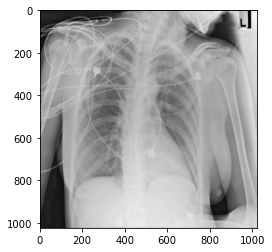

In [47]:
# Let's have a closer look on some of the images including Pneumonia

plt.imshow(mpimg.imread('/data/images_004/images/00008470_008.png'), cmap='gray')

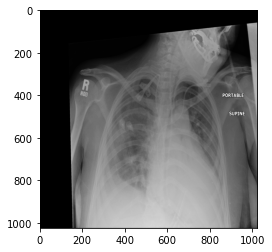

In [48]:
plt.imshow(mpimg.imread('/data/images_006/images/00011702_043.png'), cmap='gray')

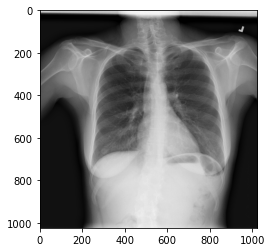

In [49]:
plt.imshow(mpimg.imread('/data/images_006/images/00012158_025.png'), cmap='gray')

From the 3 examples one can gain an idea that a light shadow indicates Pneumonia. <br> Let's deep dive into the Pixel level from here:

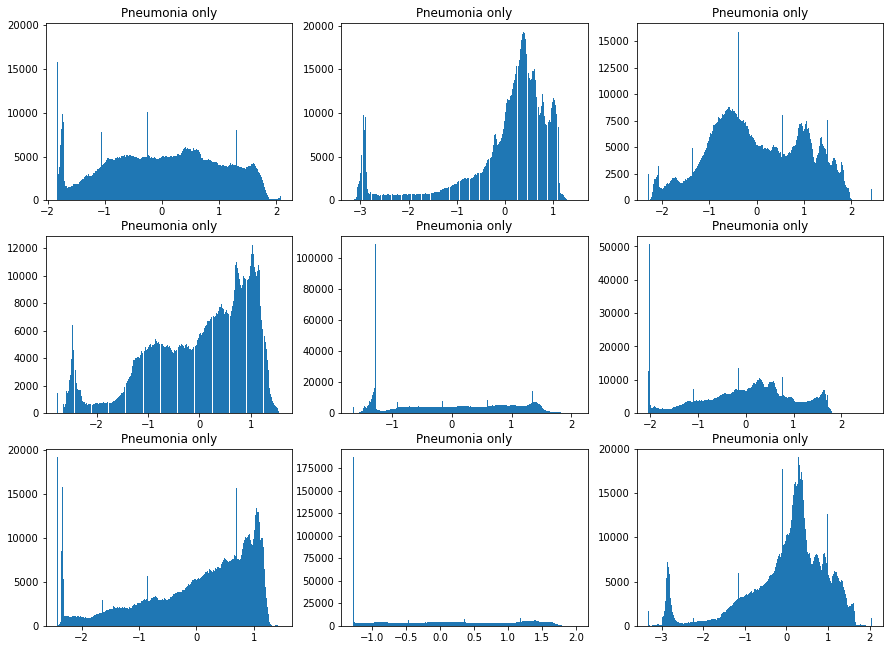

In [81]:
# We aspire to show some normalized examples of Pixel level distribution of some Pneumonia images:

plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('Pneumonia only')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

Some of the pictures indicate that we will definitely have to put Otsu's method to use in model building, as high peaks occur on sides of some images. <br>
Pixel distribution of Pneumonia does not show a clear distribution for the human eye, model accuracy might be challenging to achieve. <br>
In image augmentation we might have to align view position, as some graphs show pixel peaks to the left, others to the right of the normalized curves. <br>
How does the pixel distribution compare to non-pneumonia cases?

In [51]:
hist = sample_df[sample_df['No Finding'] == 1]
data = []
for p in range(9):
    data.append(('No Finding', hist.iloc[p]['path_img']))

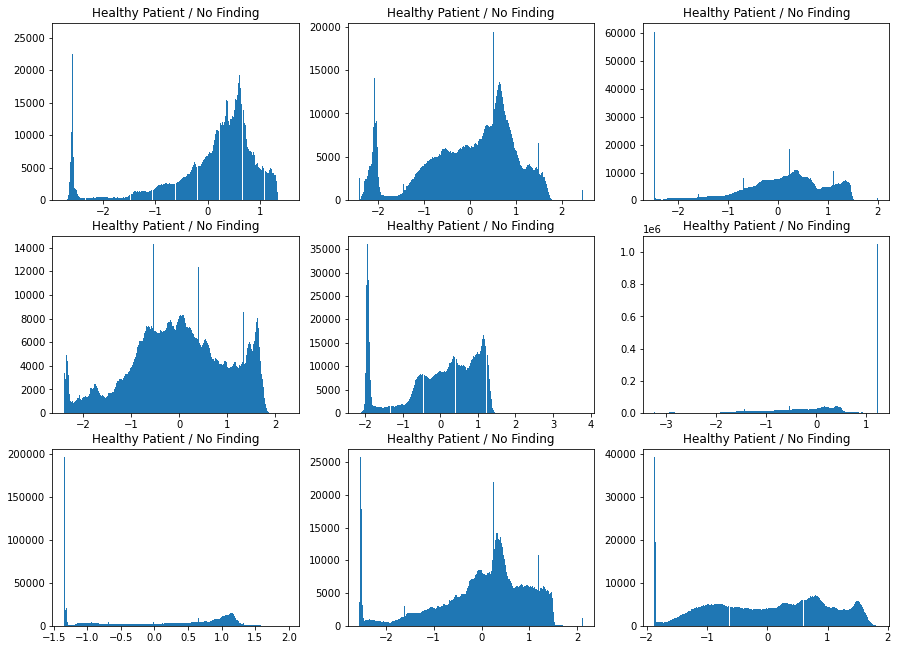

In [52]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('Healthy Patient / No Finding')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

One gets the idea that a lightly higher peak in pixel disctribution occurs in Non-Pneumonia cases around the normalized 0. But this needs some further investigation on data preparation for model building (not now here on the sample data). <br>
But one gets the feeling that this is going to be a challenging task!

#### Image level comparison of diseases

From here some further exemplary histograms are shown per disease, to gain an understanding where similarities or differences might lie.

In [53]:
hist = sample_df[(sample_df['Infiltration'] == 1) & (sample_df['sum'] == 1)]
data = []
for p in range(9):
    data.append(('Infiltration', hist.iloc[p]['path_img']))

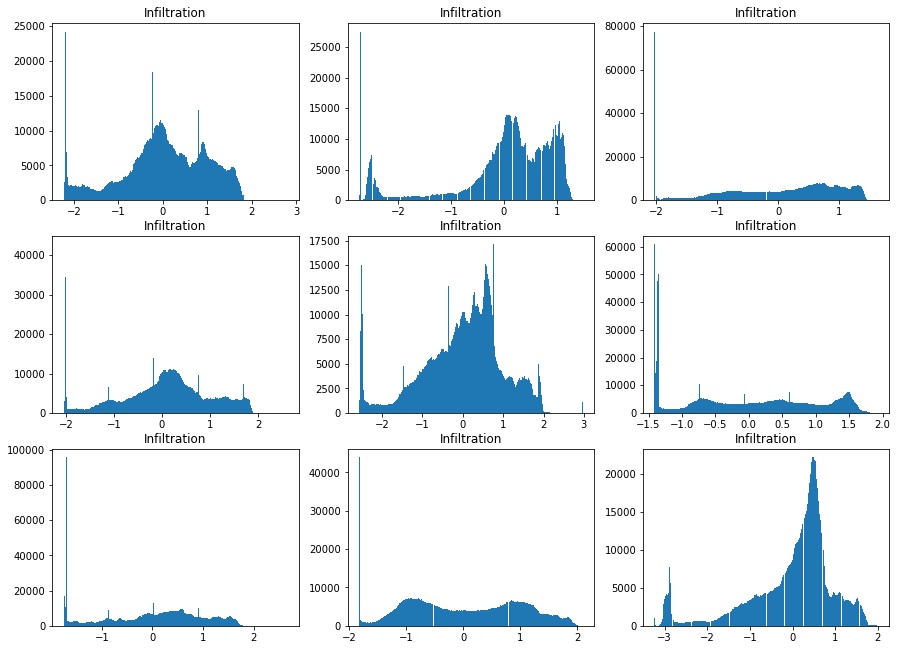

In [54]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('Infiltration')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

No bigger similarity.

In [55]:
hist = sample_df[(sample_df['Effusion'] ==1)  & (sample_df['sum'] == 1)]
data = []
for p in range(9):
    data.append(('Effusion', hist.iloc[p]['path_img']))

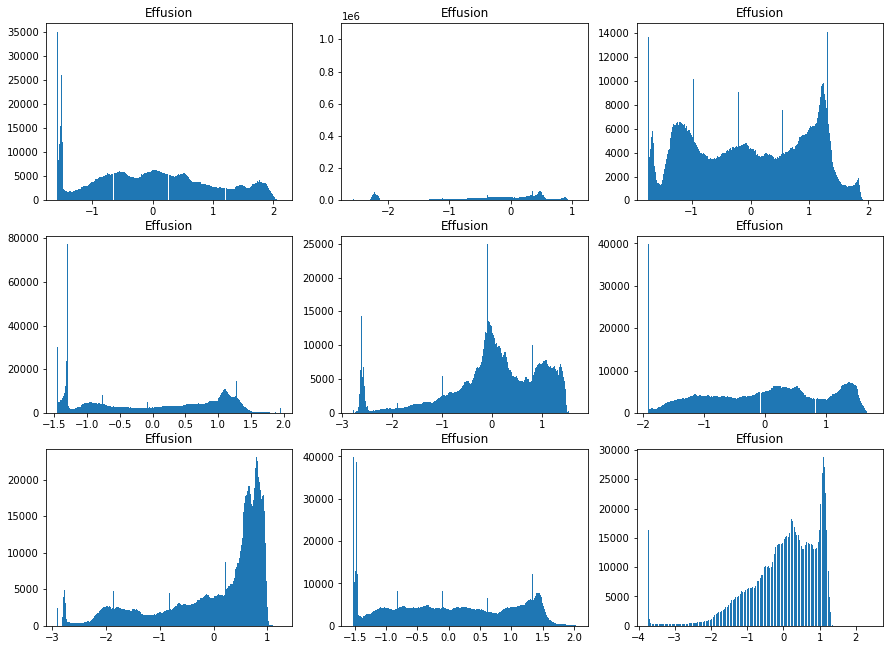

In [56]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('Effusion')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

No bigger similarity.

In [57]:
hist = sample_df[(sample_df['Edema'] ==1) & (sample_df['sum'] == 1)]
data = []
for p in range(9):
    data.append(('Edema', hist.iloc[p]['path_img']))

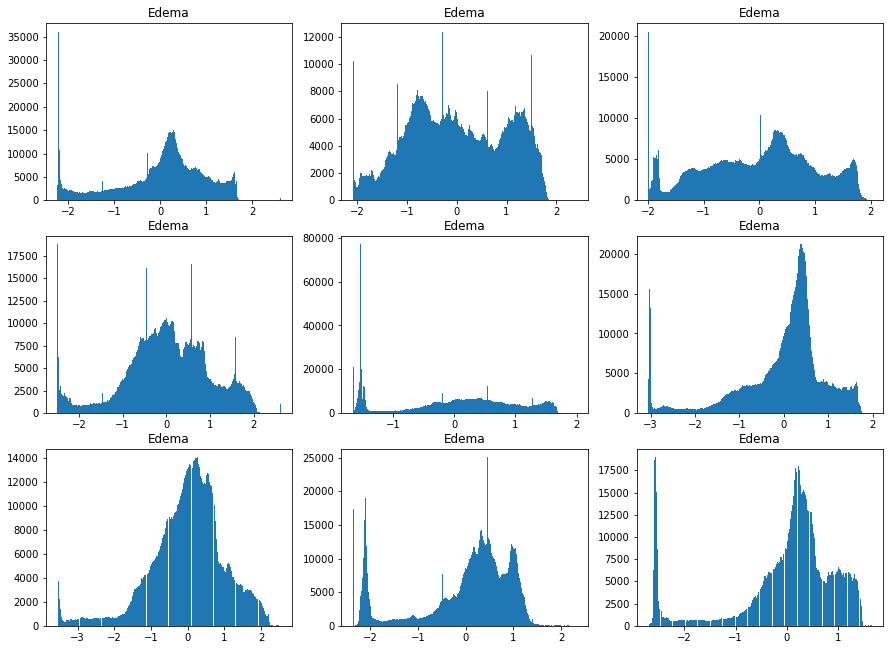

In [58]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('Edema')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

No bigger similarity.

In [59]:
hist = sample_df[(sample_df['Atelectasis'] ==1) & (sample_df['sum'] == 1)]
data = []
for p in range(9):
    data.append(('Atelectasis', hist.iloc[p]['path_img']))

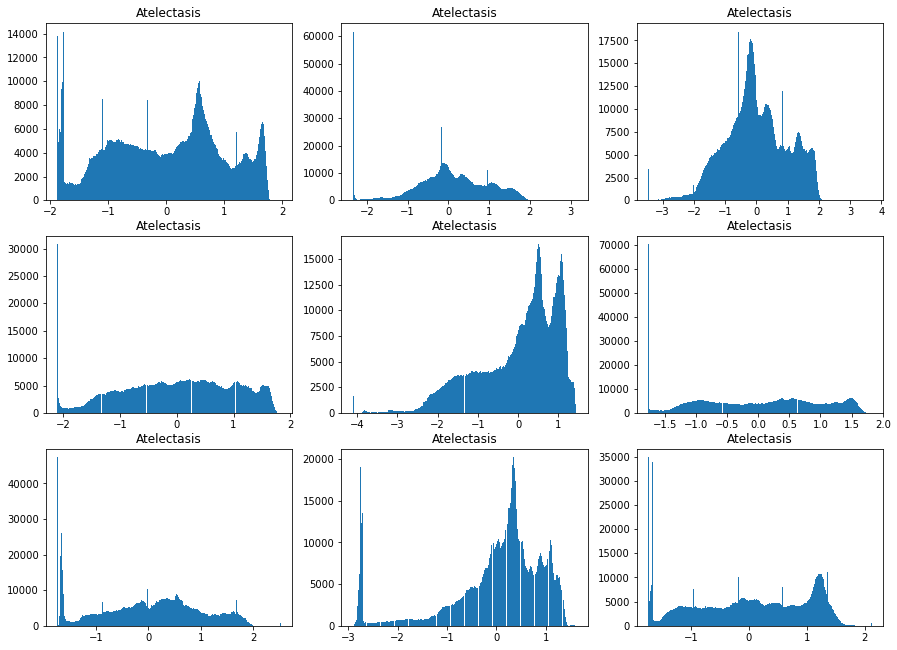

In [60]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('Atelectasis')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

No bigger similarity.

In [61]:
hist = sample_df[(sample_df['Cardiomegaly'] ==1) & (sample_df['sum'] == 1)]
data = []
for p in range(9):
    data.append(('Cardiomegaly', hist.iloc[p]['path_img']))

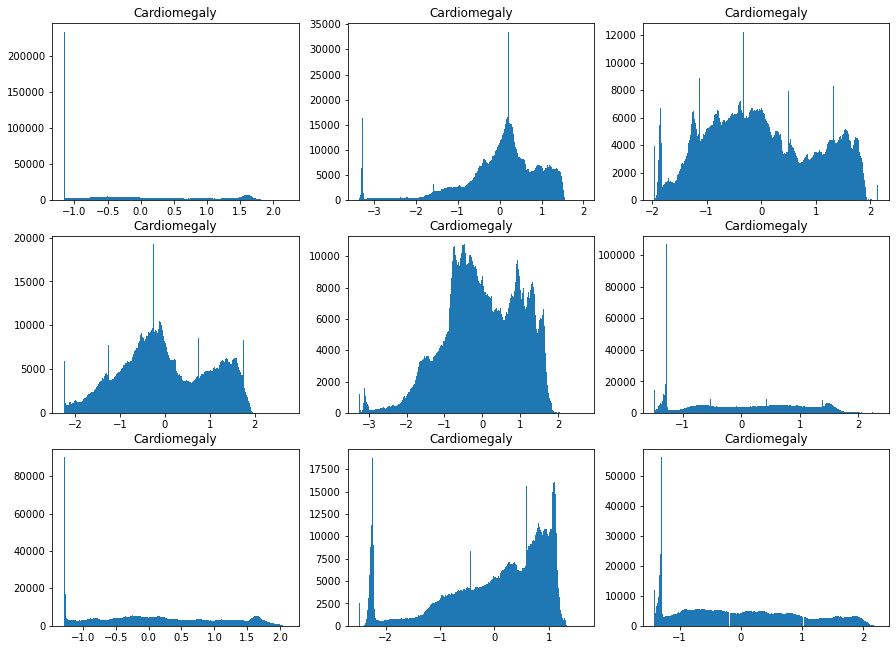

In [62]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('Cardiomegaly')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

No bigger similarity.

In [63]:
hist = sample_df[(sample_df['Consolidation'] ==1) & (sample_df['sum'] == 1)]
data = []
for p in range(9):
    data.append(('Consolidation', hist.iloc[p]['path_img']))

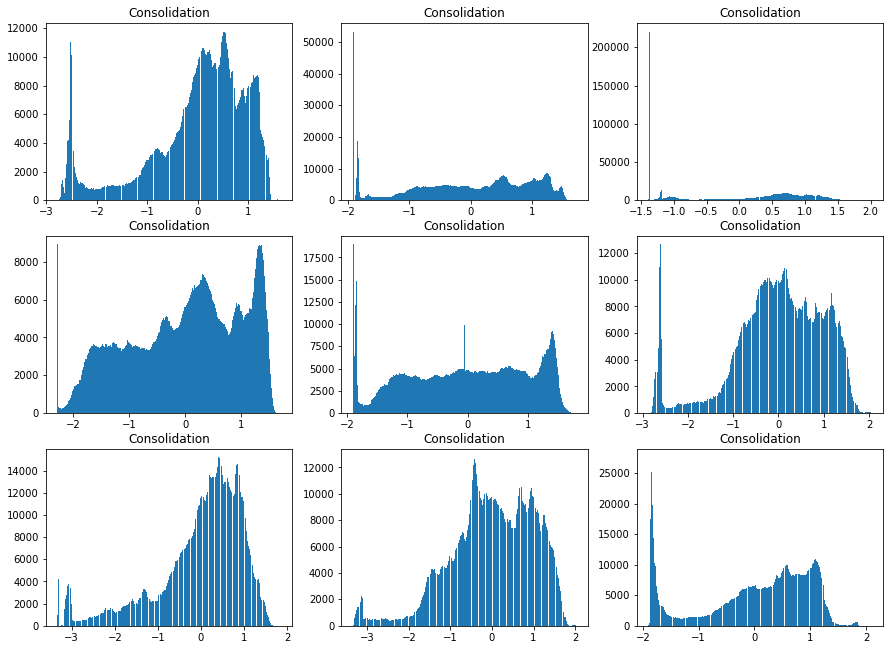

In [64]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('Consolidation')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

No bigger similarity.

In [65]:
hist = sample_df[(sample_df['Emphysema'] ==1) & (sample_df['sum'] == 1)]
data = []
for p in range(9):
    data.append(('Emphysema', hist.iloc[p]['path_img']))

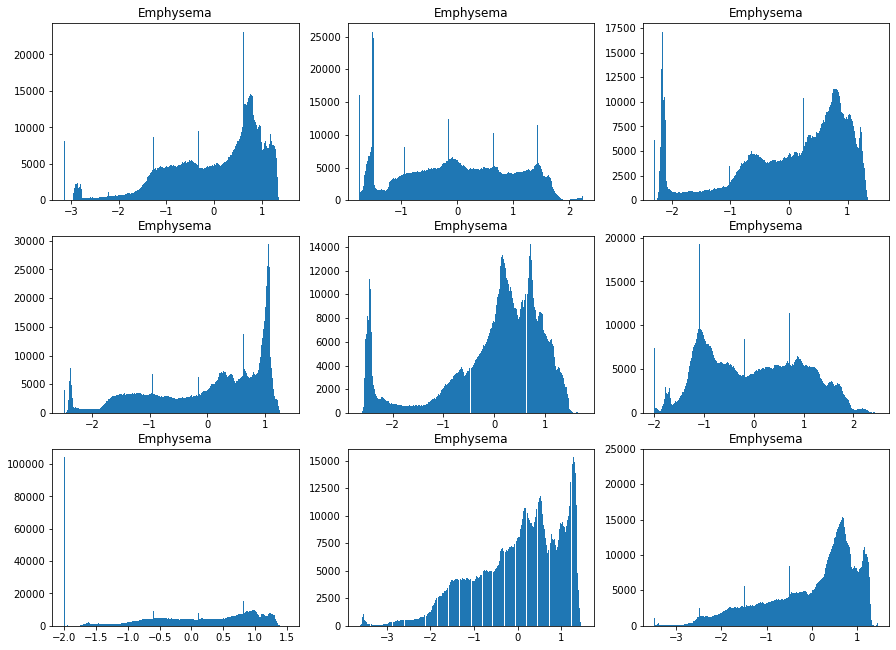

In [66]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('Emphysema')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

No bigger similarity.

In [67]:
hist = sample_df[(sample_df['Fibrosis'] ==1) & (sample_df['sum'] == 1)]
data = []
for p in range(9):
    data.append(('Fibrosis', hist.iloc[p]['path_img']))

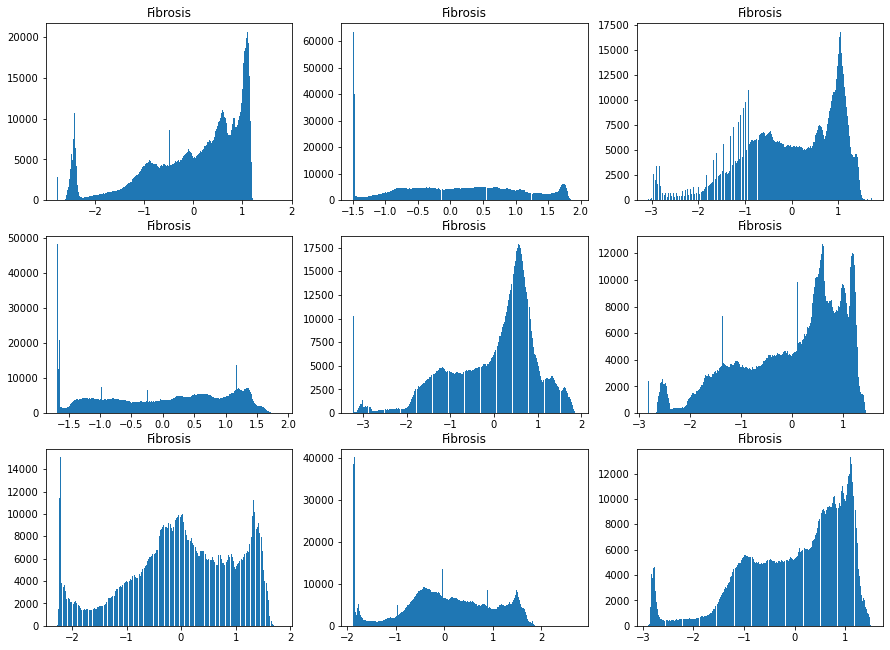

In [68]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('Fibrosis')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

Certain similarity.

In [70]:
hist = sample_df[(sample_df['Hernia'] ==1)]
data = []
for p in range(9):
    data.append(('Hernia', hist.iloc[p]['path_img']))

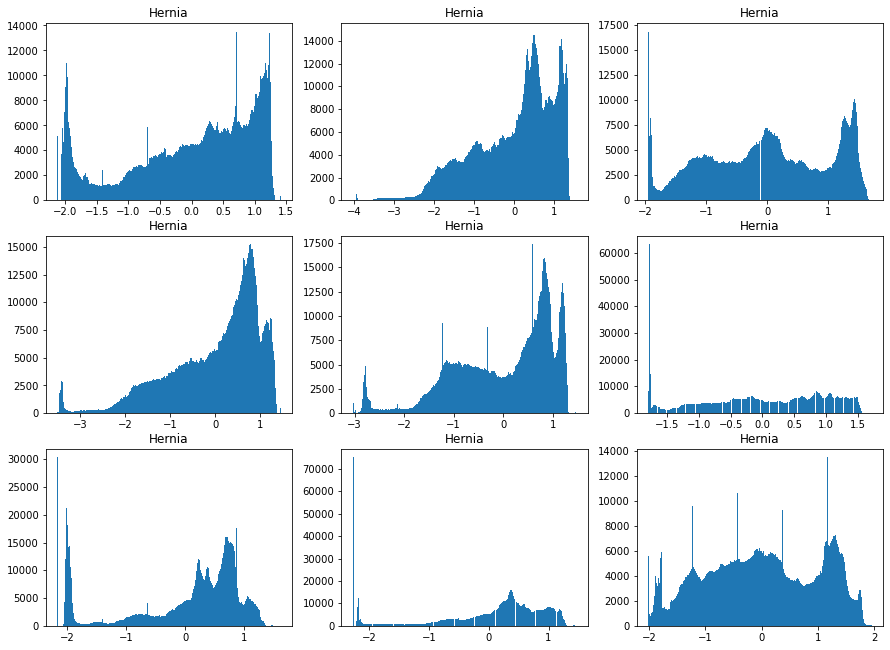

In [71]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('Hernia')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

No bigger similarity.

In [72]:
hist = sample_df[(sample_df['Mass'] ==1) & (sample_df['sum'] == 1)]
data = []
for p in range(9):
    data.append(('Mass', hist.iloc[p]['path_img']))

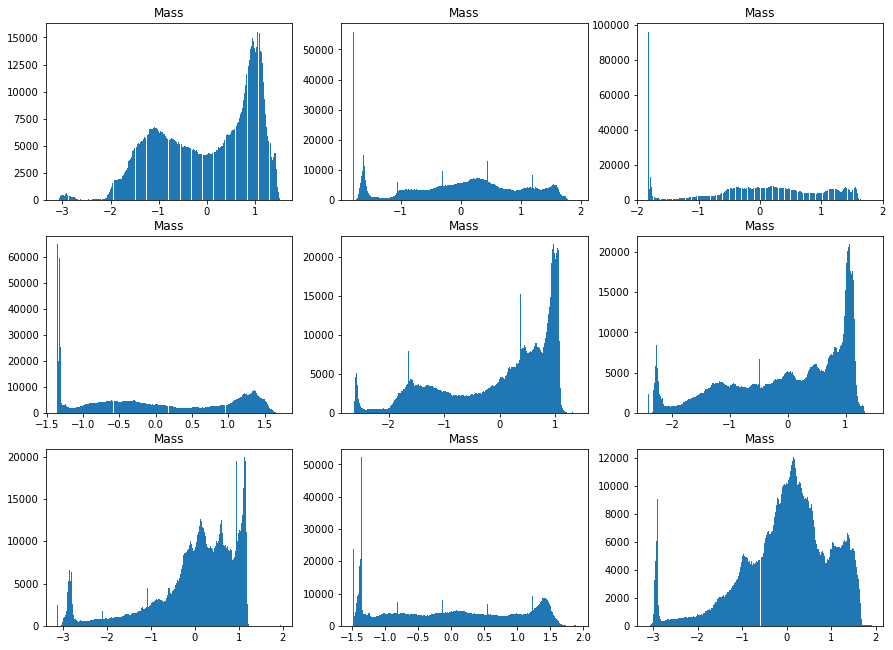

In [73]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('Mass')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

No bigger similarity.

In [74]:
hist = sample_df[(sample_df['Nodule'] ==1) & (sample_df['sum'] == 1)]
data = []
for p in range(9):
    data.append(('Nodule', hist.iloc[p]['path_img']))

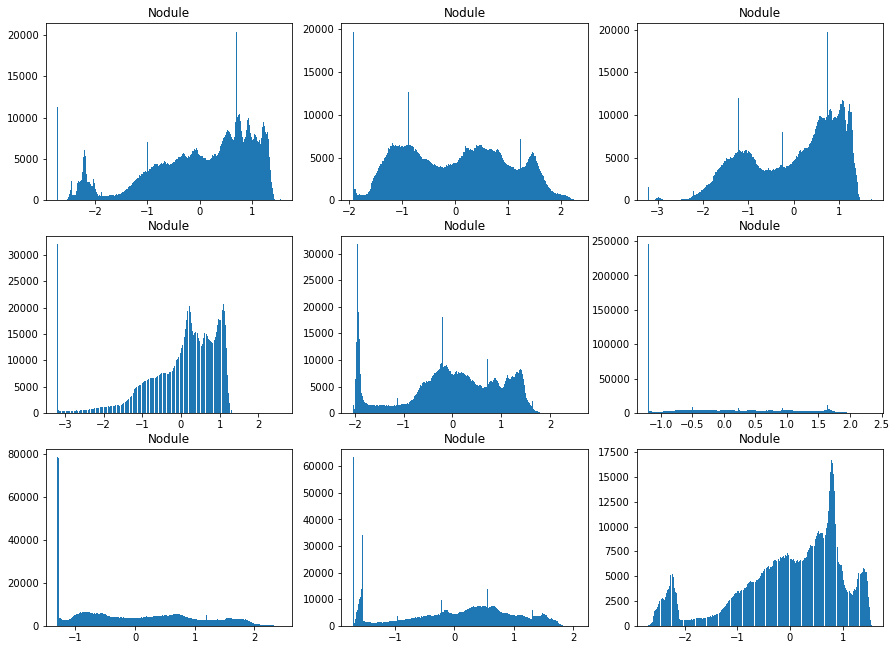

In [75]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('Nodule')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

No bigger similarity.

In [76]:
hist = sample_df[(sample_df['Pleural_Thickening'] ==1) & (sample_df['sum'] == 1)]
data = []
for p in range(9):
    data.append(('Pleural_Thickening', hist.iloc[p]['path_img']))

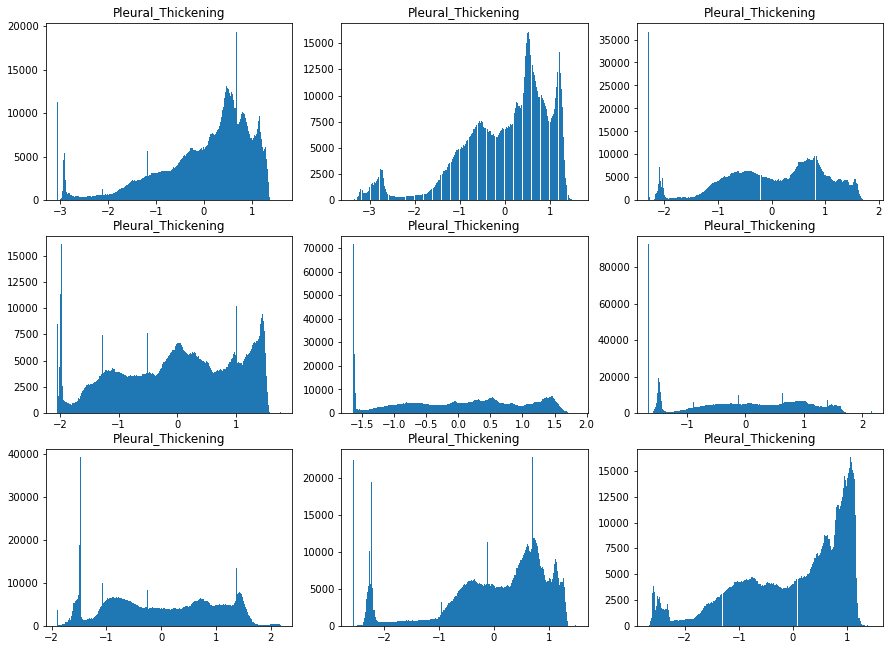

In [77]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('Pleural_Thickening')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

Certain similarity.

In [78]:
hist = sample_df[(sample_df['Pneumothorax'] ==1) & (sample_df['sum'] == 1)]
data = []
for p in range(9):
    data.append(('Pneumothorax', hist.iloc[p]['path_img']))

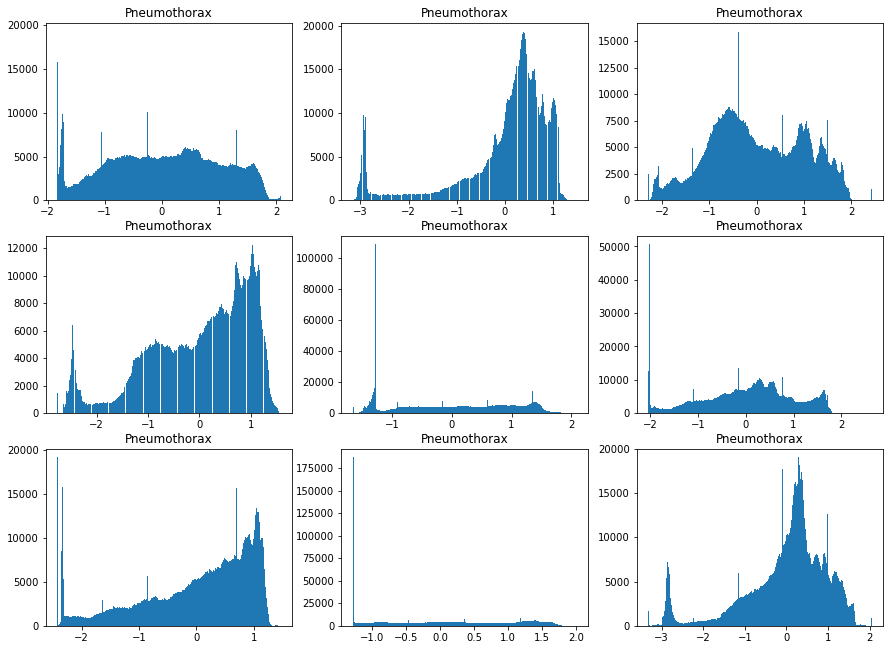

In [79]:
plt.figure(figsize=(15, 15))
columns = 3
for i in range(len(data) ):
    plt.subplot(len(data) / columns + 1, columns, i + 1).set_title('Pneumothorax')
    var = plt.imread(data[i][1])
    plt.hist(((var - np.mean(var))/np.std(var)).ravel(), bins=250)

We can see that pleural thickening, pneumothorax and fibrosis might be critical to change the performance of the model due to their relative similarity with the pixel intensity distribution of pneumonia. To be kept in mind for the model building process.